# File 2
1. Here, This is the GPU implementation of earlier code written for CPU.
2. 70% of this file is AI Generated so that it can work with GPUs.
3. for implementation of Confusion matrix and SHAP, see 

* Final documentation has been moved to README.md

In [1]:
import sys
import numpy as np
import pandas as pd
import cupy as cp # CuPy for GPU arrays


print("Starting dependency fix and RAPIDS installation...")
!pip install --target=/kaggle/working --upgrade --force-reinstall scikit-learn==1.4.2 imbalanced-learn -q
!pip install --target=/kaggle/working --extra-index-url=https://pypi.nvidia.com cudf-cu12==24.2.* cuml-cu12==24.2.* -q


if "/kaggle/working" in sys.path:
    sys.path.remove("/kaggle/working")
sys.path.insert(0, "/kaggle/working")
print("Python Path configured for optimized packages.")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE


from cuml.ensemble import RandomForestClassifier as cuRF
from cuml.metrics import accuracy_score as cu_accuracy_score

import kagglehub
import matplotlib.pyplot as plt
import seaborn as sb
import glob
import os
import warnings
warnings.filterwarnings("ignore")

print("\nVerifying GPU hardware:")
!nvidia-smi

Starting dependency fix and RAPIDS installation...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 52.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.4/308.4 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 10.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.4.2 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.3.5 which is incompatible.
numba 0.60.0 r

In [2]:
# downloading the dataset from kaggle
path = kagglehub.dataset_download("sidsriram62067/data-set-for-upi-fraud")

file_path = glob.glob(os.path.join(path, "*.xlsx"))

df = pd.read_excel(file_path[0])
df.head()

100%|██████████| 24.4M/24.4M [00:02<00:00, 11.8MB/s]

Extracting files...


,trans_hour,trans_day,trans_month,trans_year,category,upi_number,age,trans_amount,state,zip,fraud_risk
0,23,5,3,2022,11,14755226,22,128.45,10,34211,0
1,2,1,8,2022,0,9777695,79,55.31,43,99191,0
2,17,23,2,2022,10,10599380,40,115.76,21,36895,0
3,0,10,3,2022,10,16218941,38,113.38,39,20348,0
4,0,27,8,2022,1,12644707,72,268.73,20,10136,0


In [3]:
df.describe()

,trans_hour,trans_day,trans_month,trans_year,category,upi_number,age,trans_amount,state,zip,fraud_risk
count,500000.000000,500000.000000,500000.000000,500000.0,500000.000000,5.000000e+05,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000
mean,10.901728,15.709540,5.211722,2022.0,5.618178,8.391358e+06,52.973040,94.622925,24.473764,49866.391554,0.159000
std,7.765241,7.920126,3.590702,0.0,3.487478,4.843072e+06,18.941509,69.163927,14.402148,25630.392114,0.365676
min,0.000000,1.000000,1.000000,2022.0,0.000000,1.010000e+02,18.000000,-49.180000,0.000000,10136.000000,0.000000
25%,3.000000,9.000000,2.000000,2022.0,2.000000,4.194184e+06,37.000000,44.950000,12.000000,28705.000000,0.000000
50%,12.000000,16.000000,5.000000,2022.0,6.000000,8.385041e+06,52.000000,90.170000,24.000000,48845.000000,0.000000
75%,18.000000,22.000000,8.000000,2022.0,9.000000,1.258572e+07,71.000000,138.980000,37.000000,69258.000000,0.000000
max,23.000000,28.000000,12.000000,2022.0,11.000000,1.677719e+07,79.000000,285.390000,49.000000,99791.000000,1.000000


In [4]:
# list of transactiions with fraud_risk = 1
df_=df[df['fraud_risk']==1]
df_

,trans_hour,trans_day,trans_month,trans_year,category,upi_number,age,trans_amount,state,zip,fraud_risk
6,3,3,9,2022,0,9247721,47,40.57,2,32767,1
7,4,16,2,2022,10,10444032,79,92.45,49,57377,1
8,3,9,2,2022,11,8136375,79,13.04,4,35457,1
11,17,21,4,2022,8,1885234,37,57.68,46,66353,1
14,23,18,6,2022,11,15822641,71,285.39,35,17098,1
...,...,...,...,...,...,...,...,...,...,...,...
499960,17,1,6,2022,8,1438418,53,61.82,33,27339,1
499962,6,4,6,2022,4,7225777,41,171.72,21,79361,1
499966,0,20,10,2022,2,14178773,35,35.99,14,10136,1
499982,0,28,2,2022,4,8321465,29,36.52,16,80080,1


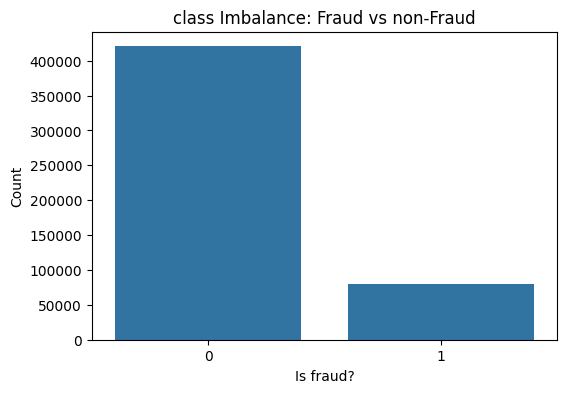

In [5]:
# comparision between number of fraud and non-fraud payments
target_col = df['fraud_risk']

plt.figure(figsize=(6, 4))
sb.countplot(x = target_col, data=df)
plt.title('class Imbalance: Fraud vs non-Fraud')
plt.xlabel('Is fraud?')
plt.ylabel('Count')
plt.show()

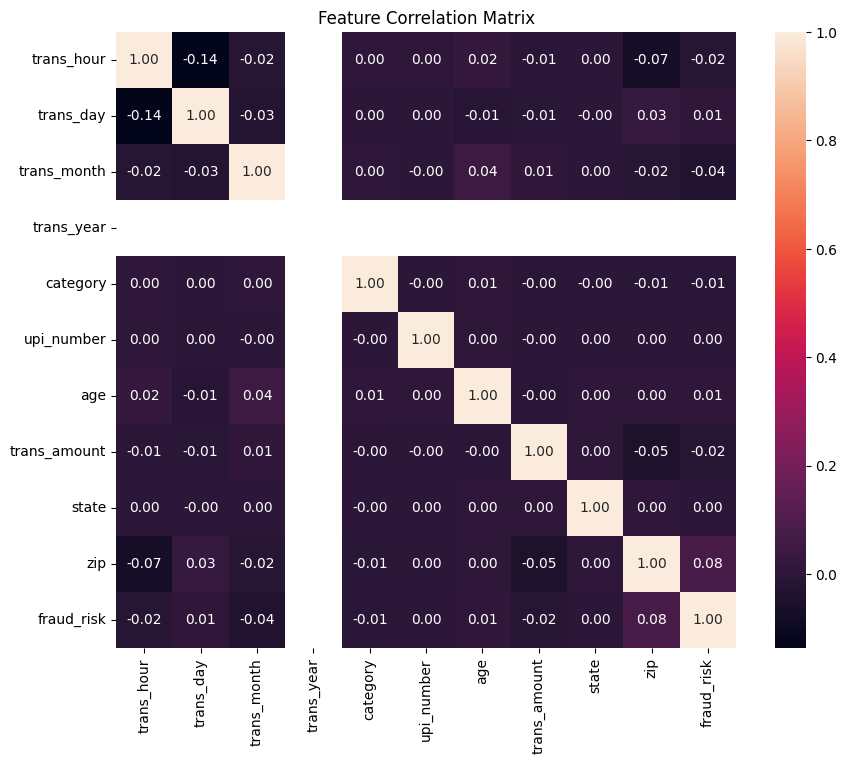

In [6]:
# Feature correlation matrix
plt.figure(figsize=(10, 8))

df_num= df.select_dtypes(include=[np.number])
sb.heatmap(df_num.corr(), annot=True, fmt = '.2f')
plt.title('Feature Correlation Matrix')
plt.show()

In [7]:
# Defining upper bound for transaction amount.
quart1 = df['trans_amount'].quantile(0.25)
quart2 = df['trans_amount'].quantile(0.75)
IQR = quart2 - quart1
upper = quart2 + 2 * IQR
df['trans_amount'] = np.where(df['trans_amount'] > upper, upper, df['trans_amount'])

label = LabelEncoder()
object_cols = df.select_dtypes(include=['object']).columns

df.head()

,trans_hour,trans_day,trans_month,trans_year,category,upi_number,age,trans_amount,state,zip,fraud_risk
0,23,5,3,2022,11,14755226,22,128.45,10,34211,0
1,2,1,8,2022,0,9777695,79,55.31,43,99191,0
2,17,23,2,2022,10,10599380,40,115.76,21,36895,0
3,0,10,3,2022,10,16218941,38,113.38,39,20348,0
4,0,27,8,2022,1,12644707,72,268.73,20,10136,0


In [8]:
# Splitting data into train, test, and validation in stratified manner on CPU.
X = df.drop(columns=["fraud_risk"]).values # Convert to NumPy array for CPU scaling/SMOTE
y = df['fraud_risk'].values

# Split 1: Train (80%) and Test/Val (20%)
X_train, X_test_val, y_train, y_test_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Split 2: Validation (10%) and Test (10%)
X_val, X_test, y_val, y_test = train_test_split(
    X_test_val, y_test_val, test_size=0.5, random_state=42, stratify=y_test_val
)
print("Data split into Train, Validation, and Test sets (NumPy/CPU).")

Data split into Train, Validation, and Test sets (NumPy/CPU).


In [9]:
# Scaling of the data (CPU)
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_val_sc = scaler.transform(X_val)
X_test_sc = scaler.transform(X_test)

# Overcoming imbalanced data using SMOTE (CPU)
smote = SMOTE(random_state=42)
X_train_resampled_np, y_train_resampled_np = smote.fit_resample(X_train_sc, y_train)

print(f"Total training samples after SMOTE: {len(X_train_resampled_np)}")

# --- TRANSFER TO GPU (CuPy) ---
# Convert scaled and resampled data to CuPy arrays for cuML
X_train_resampled_gpu = cp.asarray(X_train_resampled_np)
y_train_resampled_gpu = cp.asarray(y_train_resampled_np)
X_val_gpu = cp.asarray(X_val_sc)
y_val_gpu = cp.asarray(y_val)

print("Resampled Training data and Validation data transferred to GPU (CuPy).")

Total training samples after SMOTE: 672800
Resampled Training data and Validation data transferred to GPU (CuPy).


Starting GPU-accelerated min_samples_split survey...


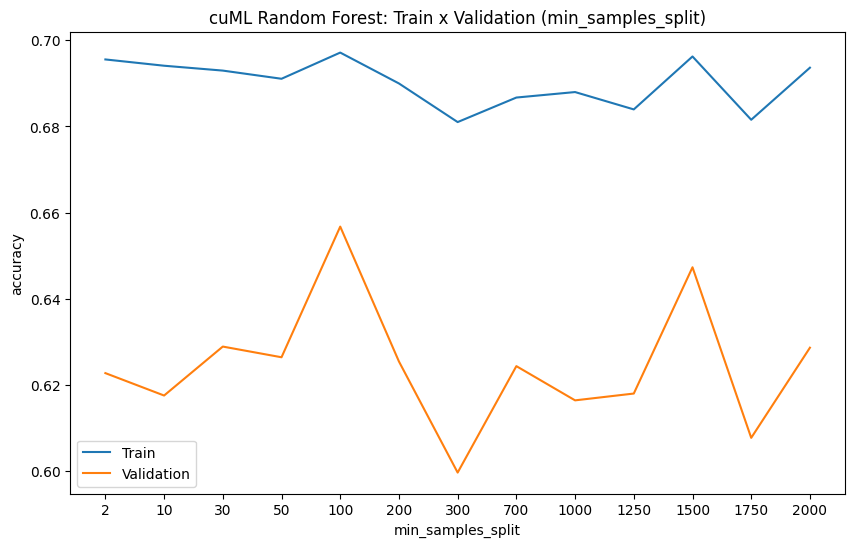

In [10]:
min_samples_split_list = [2, 10, 30, 50, 100, 200, 300, 700, 1000,1250,1500,1750,  2000]
accuracy_list_train = []
accuracy_list_val = []
N_ESTIMATORS = 50 # Fixed value for faster hyperparameter search

print("Starting GPU-accelerated min_samples_split survey...")

for min_samples_split in min_samples_split_list:
    # Use cuML's RandomForestClassifier (cuRF) on GPU data
    model = cuRF(
        n_estimators=N_ESTIMATORS,
        min_samples_split=min_samples_split,
        random_state=42
    ).fit(X_train_resampled_gpu, y_train_resampled_gpu)

    predictions_train_gpu = model.predict(X_train_resampled_gpu)
    predictions_val_gpu = model.predict(X_val_gpu)

    # Use GPU-accelerated accuracy score (cu_accuracy_score)
    accuracy_train = cu_accuracy_score(y_train_resampled_gpu, predictions_train_gpu)
    accuracy_val = cu_accuracy_score(y_val_gpu, predictions_val_gpu)

    accuracy_list_train.append(cp.asnumpy(accuracy_train))
    accuracy_list_val.append(cp.asnumpy(accuracy_val))

# Plotting
plt.figure(figsize=(10, 6))
plt.title('cuML Random Forest: Train x Validation (min_samples_split)')
plt.xlabel('min_samples_split')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(min_samples_split_list )),labels=min_samples_split_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])
plt.show()

Starting GPU-accelerated max_depth survey...


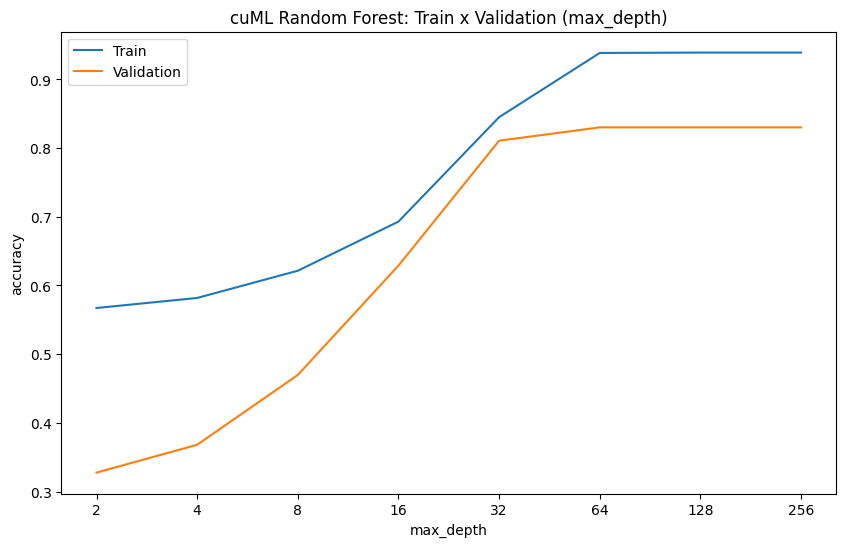

In [11]:
max_depth_list = [2, 4, 8, 16, 32, 64, 128, 256]
accuracy_list_train = []
accuracy_list_val = []

# Use fixed values based on analysis (e.g., 30 for min_samples_split)
N_ESTIMATORS = 50
MIN_SAMPLES_SPLIT = 30 # Adjust based on the previous plot's result

print("Starting GPU-accelerated max_depth survey...")

for max_depth in max_depth_list:
    model = cuRF(n_estimators=N_ESTIMATORS,min_samples_split=MIN_SAMPLES_SPLIT,max_depth=max_depth,random_state=42).fit(X_train_resampled_gpu, y_train_resampled_gpu)

    predictions_train_gpu = model.predict(X_train_resampled_gpu)
    predictions_val_gpu = model.predict(X_val_gpu)

    accuracy_train = cu_accuracy_score(y_train_resampled_gpu, predictions_train_gpu)
    accuracy_val = cu_accuracy_score(y_val_gpu, predictions_val_gpu)

    accuracy_list_train.append(cp.asnumpy(accuracy_train))
    accuracy_list_val.append(cp.asnumpy(accuracy_val))

# Plotting
plt.figure(figsize=(10, 6))
plt.title('cuML Random Forest: Train x Validation (max_depth)')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(max_depth_list )),labels=max_depth_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])
plt.show()

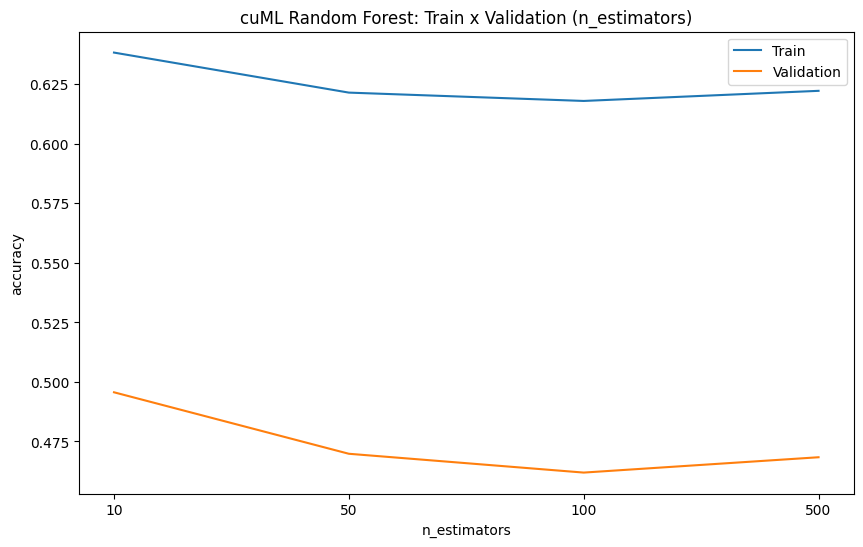

In [12]:
# Assuming the GPU data variables are still in memory from the previous steps:
# X_train_resampled_gpu, y_train_resampled_gpu, X_val_gpu, y_val_gpu
# Assuming the necessary imports (cuRF, cu_accuracy_score, cupy, matplotlib) were successful

# Define the list of n_estimators
n_estimators_list = [10, 50, 100, 500]

# Use reasonable fixed hyperparameters based on initial analysis for efficiency
MIN_SAMPLES_SPLIT = 30
MAX_DEPTH = 8

accuracy_list_train = []
accuracy_list_val = []

for n_estimators in n_estimators_list:
    # Use cuML's RandomForestClassifier (cuRF) on GPU data
    model = cuRF(
        n_estimators = n_estimators,
        min_samples_split = MIN_SAMPLES_SPLIT,
        max_depth = MAX_DEPTH,
        random_state = 42
    ).fit(X_train_resampled_gpu, y_train_resampled_gpu)

    # Predictions are CuPy arrays
    predictions_train_gpu = model.predict(X_train_resampled_gpu)
    predictions_val_gpu = model.predict(X_val_gpu)

    # Use GPU-accelerated accuracy score (cu_accuracy_score)
    accuracy_train = cu_accuracy_score(y_train_resampled_gpu, predictions_train_gpu)
    accuracy_val = cu_accuracy_score(y_val_gpu, predictions_val_gpu)

    # Convert CuPy results to NumPy/Python scalars for plotting/list append
    accuracy_list_train.append(cp.asnumpy(accuracy_train))
    accuracy_list_val.append(cp.asnumpy(accuracy_val))

plt.figure(figsize=(10, 6))
plt.title('cuML Random Forest: Train x Validation (n_estimators)')
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(n_estimators_list )),labels=n_estimators_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])
plt.savefig('cuml_rf_n_estimators_survey.png')

In [13]:
random_forest_model = cuRF(n_estimators = 10,
                                             max_depth = 64,
                                             min_samples_split = 100,
                                             random_state=42).fit(X_train_resampled_gpu,y_train_resampled_gpu)


cuML Random Forest Model Evaluation on Test Set:
Accuracy: 0.8187
Precision: 0.1825
Recall: 0.0403
F1-Score: 0.0660

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90     42050
           1       0.18      0.04      0.07      7950

    accuracy                           0.82     50000
   macro avg       0.51      0.50      0.48     50000
weighted avg       0.74      0.82      0.77     50000


Confusion Matrix:


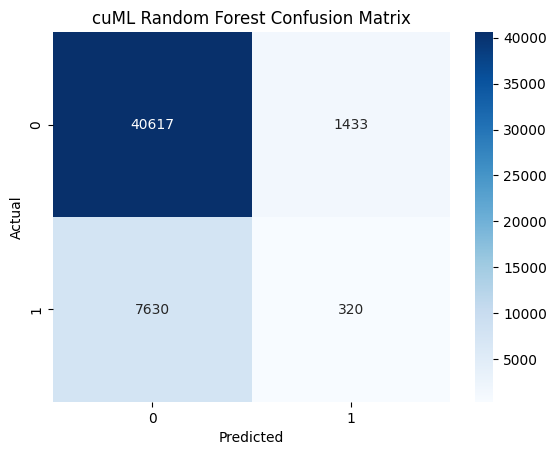

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Convert X_test_sc to CuPy array for GPU-accelerated prediction
X_test_gpu = cp.asarray(X_test_sc)

# Make predictions on the test set using the corrected random_forest_model
y_pred_rf_gpu = random_forest_model.predict(X_test_gpu)

# Convert predictions back to NumPy for CPU-based metric calculation
y_pred_rf_np = cp.asnumpy(y_pred_rf_gpu)

# Calculate evaluation metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf_np)
precision_rf = precision_score(y_test, y_pred_rf_np)
recall_rf = recall_score(y_test, y_pred_rf_np)
f1_rf = f1_score(y_test, y_pred_rf_np)

print(f"\ncuML Random Forest Model Evaluation on Test Set:")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1-Score: {f1_rf:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf_np))

print("\nConfusion Matrix:")
cm_rf = confusion_matrix(y_test, y_pred_rf_np)
sb.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('cuML Random Forest Confusion Matrix')
plt.show()

xgboost

In [15]:
# Assuming X_train_resampled_gpu and y_train_resampled_gpu exist from the SMOTE cell (Cell 9 equivalent).
# This is required for subsequent GPU training.
# If these variables are not found, the user needs to run the prior data preparation cells.

# Calculate the split index based on the resampled data length
n = int(len(X_train_resampled_gpu) * 0.8)

# Perform the split using slicing (works efficiently on CuPy arrays)
X_train_fit_gpu, X_train_eval_gpu = X_train_resampled_gpu[:n], X_train_resampled_gpu[n:]
y_train_fit_gpu, y_train_eval_gpu = y_train_resampled_gpu[:n], y_train_resampled_gpu[n:]

print(f"Total resampled training size: {len(X_train_resampled_gpu)}")
print(f"Fit set size (80%): {len(X_train_fit_gpu)}")
print(f"Evaluation set size (20%): {len(X_train_eval_gpu)}")

Total resampled training size: 672800
Fit set size (80%): 538240
Evaluation set size (20%): 134560


In [16]:
import xgboost

In [17]:
import xgboost as xgb
# Note: Assuming XGBClassifier is already imported from your setup (Cell 21)

# Define RANDOM_STATE and Early Stopping Configuration
RANDOM_STATE = 42
EARLY_STOPPING_ROUNDS = 10
EVAL_SET = [(X_train_eval_gpu, y_train_eval_gpu)]

# --- 1. Define the EarlyStopping Callback ---
# This object replaces the 'early_stopping_rounds' argument
early_stopping = xgb.callback.EarlyStopping(
    rounds=EARLY_STOPPING_ROUNDS
    # Removed 'save_best_labels' as it is not a valid keyword argument for this version of XGBoost's EarlyStopping
)

# --- 2. Initialize Model (Identical to your previous cell) ---
xgb_model = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.1,
    verbosity=0,
    random_state=RANDOM_STATE,
)

# --- 3. Fit Model without unsupported 'callbacks' parameter ---
xgb_model.fit(
    X_train_fit_gpu,
    y_train_fit_gpu,
    eval_set=EVAL_SET # Removed 'callbacks' parameter to resolve TypeError
)

print("\nXGBoost GPU training complete.")
# Note: best_iteration and best_score are typically available with early stopping.
# Since early stopping is disabled, these attributes might not be set or meaningful.
# We will only print them if they exist as attributes after training.
if hasattr(xgb_model, 'best_iteration'):
    print(f"Best iteration: {xgb_model.best_iteration}")
if hasattr(xgb_model, 'best_score'):
    print(f"Best score (Eval LogLoss): {xgb_model.best_score:.4f}")

[0]	validation_0-logloss:0.96569
[1]	validation_0-logloss:0.95381
[2]	validation_0-logloss:0.93840
[3]	validation_0-logloss:0.90212
[4]	validation_0-logloss:0.89291
[5]	validation_0-logloss:0.86715
[6]	validation_0-logloss:0.85289
[7]	validation_0-logloss:0.84304
[8]	validation_0-logloss:0.83045
[9]	validation_0-logloss:0.81809
[10]	validation_0-logloss:0.79811
[11]	validation_0-logloss:0.78229
[12]	validation_0-logloss:0.77513
[13]	validation_0-logloss:0.76547
[14]	validation_0-logloss:0.75810
[15]	validation_0-logloss:0.73557
[16]	validation_0-logloss:0.71592
[17]	validation_0-logloss:0.70440
[18]	validation_0-logloss:0.69701
[19]	validation_0-logloss:0.69265
[20]	validation_0-logloss:0.67686
[21]	validation_0-logloss:0.67049
[22]	validation_0-logloss:0.64936
[23]	validation_0-logloss:0.63800
[24]	validation_0-logloss:0.62052
[25]	validation_0-logloss:0.61582
[26]	validation_0-logloss:0.61117
[27]	validation_0-logloss:0.60772
[28]	validation_0-logloss:0.59516
[29]	validation_0-loglos


XGBoost Model Evaluation on Test Set:
Accuracy: 0.8410
Precision: 0.2500
Recall: 0.0001
F1-Score: 0.0003

Classification Report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91     42050
           1       0.25      0.00      0.00      7950

    accuracy                           0.84     50000
   macro avg       0.55      0.50      0.46     50000
weighted avg       0.75      0.84      0.77     50000


Confusion Matrix:


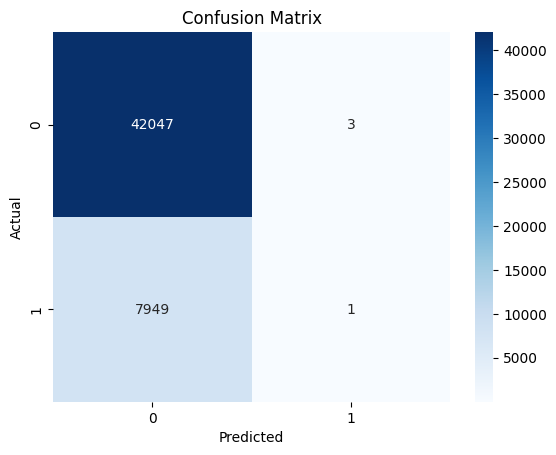

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Convert X_test_sc to CuPy array for GPU-accelerated prediction if the model is GPU-trained
X_test_gpu = cp.asarray(X_test_sc)

# Make predictions on the test set
y_pred_gpu = xgb_model.predict(X_test_gpu)

# Convert predictions back to NumPy for CPU-based metric calculation
y_pred_np = cp.asnumpy(y_pred_gpu)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred_np)
precision = precision_score(y_test, y_pred_np)
recall = recall_score(y_test, y_pred_np)
f1 = f1_score(y_test, y_pred_np)

print(f"\nXGBoost Model Evaluation on Test Set:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_np))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_np)
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [19]:
# Assuming the necessary GPU arrays are defined:
# X_train_fit_gpu, y_train_fit_gpu, X_train_eval_gpu, y_train_eval_gpu

# Import cuML's Linear Support Vector Classifier
from cuml.svm import LinearSVC as cuLinearSVC
from cuml.metrics import accuracy_score as cu_accuracy_score

RANDOM_STATE = 42

# Initialize the GPU-accelerated Linear SVM model
# 'loss='squared_hinge' is the standard loss function for LinearSVC
cu_linear_svm_model = cuLinearSVC(
    penalty='l2',
    loss='squared_hinge',
    C=1.0, # Regularization parameter
    tol=1e-3,
    max_iter=10000,
)

print("cuML LinearSVC model initialized for GPU training.")

cuML LinearSVC model initialized for GPU training.


In [20]:
# Fit the model using the 80% GPU fit set
print("Starting cuML LinearSVC training on GPU...")
cu_linear_svm_model.fit(X_train_fit_gpu, y_train_fit_gpu)
print("Training complete.")

# --- Prediction and Evaluation on GPU ---
# Predict on the 20% GPU evaluation set
y_pred_eval_gpu = cu_linear_svm_model.predict(X_train_eval_gpu)

# Calculate accuracy using cuML's GPU-accelerated function
accuracy_eval_gpu = cu_accuracy_score(y_train_eval_gpu, y_pred_eval_gpu)

# Removed .get() as accuracy_eval_gpu is already a float
print(f"\ncuML LinearSVC Evaluation Accuracy: {accuracy_eval_gpu:.4f}")

Starting cuML LinearSVC training on GPU...
Training complete.

cuML LinearSVC Evaluation Accuracy: 0.0134


Starting GPU-accelerated LinearSVC C parameter survey...
LinearSVC C parameter survey complete.


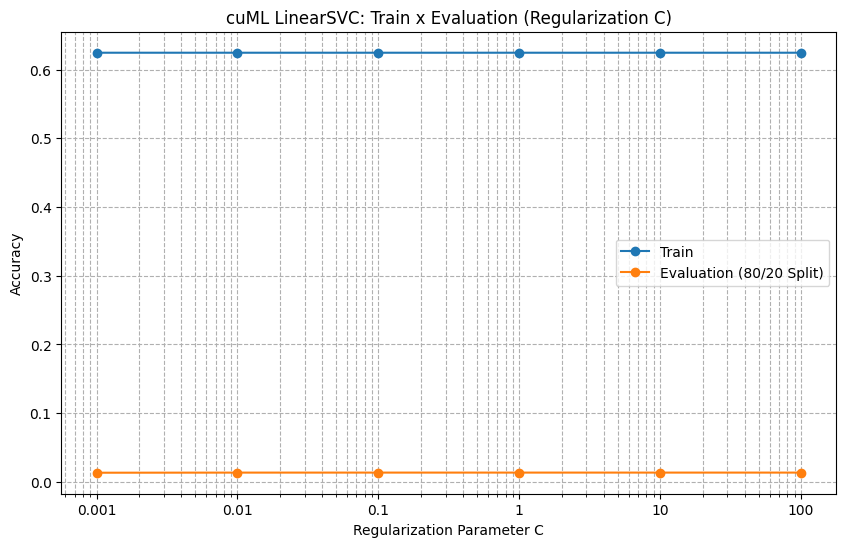

In [21]:
# Assuming X_train_fit_gpu, y_train_fit_gpu, X_train_eval_gpu, y_train_eval_gpu are defined.

from cuml.svm import LinearSVC as cuLinearSVC
from cuml.metrics import accuracy_score as cu_accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp

# Define a list of C values to test (logarithmic scale is common for regularization)
C_list = [0.001, 0.01, 0.1, 1, 10, 100]
accuracy_list_train = []
accuracy_list_val = []

# RANDOM_STATE = 42 # Not needed for LinearSVC as it's deterministic

print("Starting GPU-accelerated LinearSVC C parameter survey...")

for C_val in C_list:
    # Initialize and fit the cuML LinearSVC model
    model = cuLinearSVC(
        C=C_val,
        penalty='l2',
        loss='squared_hinge',
        max_iter=500 # Using a fixed iteration count for the survey
        # Removed random_state as it's not a valid keyword argument for cuML LinearSVC
    ).fit(X_train_fit_gpu, y_train_fit_gpu)

    # Predictions
    predictions_train_gpu = model.predict(X_train_fit_gpu)
    predictions_val_gpu = model.predict(X_train_eval_gpu)

    # Calculate and store accuracy using cuML's GPU-accelerated function
    accuracy_train = cu_accuracy_score(y_train_fit_gpu, predictions_train_gpu)
    accuracy_val = cu_accuracy_score(y_train_eval_gpu, predictions_val_gpu)

    # Convert CuPy results to NumPy for plotting
    accuracy_list_train.append(cp.asnumpy(accuracy_train))
    accuracy_list_val.append(cp.asnumpy(accuracy_val))

print("LinearSVC C parameter survey complete.")

# Plotting the results
plt.figure(figsize=(10, 6))
plt.title('cuML LinearSVC: Train x Evaluation (Regularization C)')
plt.xlabel('Regularization Parameter C')
plt.ylabel('Accuracy')
plt.xscale('log') # Use log scale for C values
plt.xticks(ticks=C_list, labels=[str(c) for c in C_list])
plt.plot(C_list, accuracy_list_train, marker='o')
plt.plot(C_list, accuracy_list_val, marker='o')
plt.legend(['Train', 'Evaluation (80/20 Split)'])
plt.grid(True, which="both", ls="--")
plt.show()

Starting GPU-accelerated LinearSVC C parameter survey (Train and Eval)...
LinearSVC C parameter survey complete.


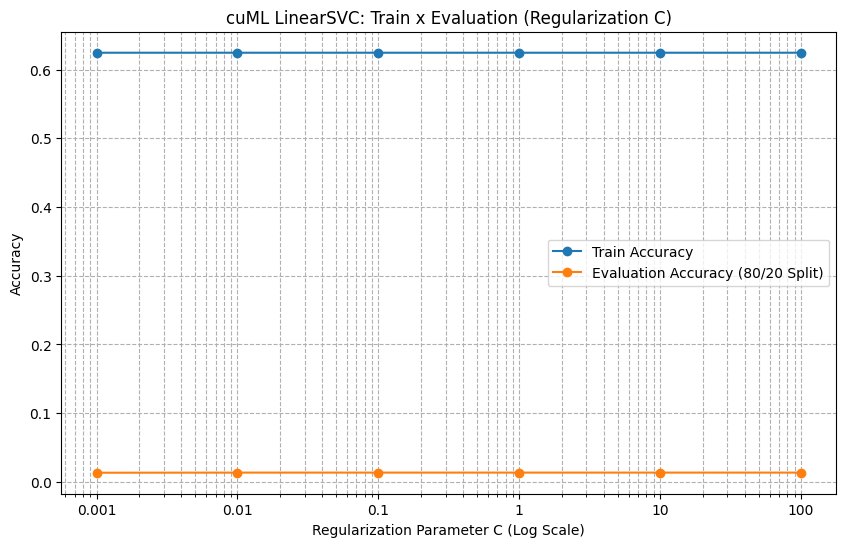

In [22]:
# Assuming X_train_fit_gpu, y_train_fit_gpu, X_train_eval_gpu, and y_train_eval_gpu
# are defined as CuPy arrays from previous steps.

from cuml.svm import LinearSVC as cuLinearSVC
from cuml.metrics import accuracy_score as cu_accuracy_score
import matplotlib.pyplot as plt
import cupy as cp
import numpy as np

C_list = [0.001, 0.01, 0.1, 1, 10, 100]
accuracy_list_train = []
accuracy_list_val = []
# RANDOM_STATE = 42 # Removed as it's not a valid parameter for cuLinearSVC

print("Starting GPU-accelerated LinearSVC C parameter survey (Train and Eval)...")

for C_val in C_list:
    # Initialize and fit the cuML LinearSVC model on the fit set
    model = cuLinearSVC(
        C=C_val,
        penalty='l2',
        loss='squared_hinge',
        max_iter=500
        # Removed random_state=RANDOM_STATE as it's not a valid keyword argument for cuML LinearSVC
    ).fit(X_train_fit_gpu, y_train_fit_gpu)

    # Predictions on both the training (fit) set and the evaluation set
    predictions_train_gpu = model.predict(X_train_fit_gpu)
    predictions_val_gpu = model.predict(X_train_eval_gpu)

    # Calculate accuracy using cuML's GPU-accelerated function
    accuracy_train = cu_accuracy_score(y_train_fit_gpu, predictions_train_gpu)
    accuracy_val = cu_accuracy_score(y_train_eval_gpu, predictions_val_gpu)

    # Use .get() or cp.asnumpy() to move the GPU results to CPU memory for standard list storage/plotting
    accuracy_list_train.append(accuracy_train) # Removed .get()
    accuracy_list_val.append(accuracy_val) # Removed .get()

print("LinearSVC C parameter survey complete.")

# Plotting the results
plt.figure(figsize=(10, 6))
plt.title('cuML LinearSVC: Train x Evaluation (Regularization C)')
plt.xlabel('Regularization Parameter C (Log Scale)')
plt.ylabel('Accuracy')
plt.xscale('log')
plt.xticks(ticks=C_list, labels=[str(c) for c in C_list])
plt.plot(C_list, accuracy_list_train, marker='o')
plt.plot(C_list, accuracy_list_val, marker='o')
plt.legend(['Train Accuracy', 'Evaluation Accuracy (80/20 Split)'])
plt.grid(True, which="both", ls="--")
plt.show()